In [1]:
import numpy as np
import os
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
class BoardEvaluator(nn.Module):
    def __init__(self, num_channels):
        super(BoardEvaluator, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Linear (Fully Connected) Layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        
        # Output Heads
        self.score_head = nn.Linear(128, 1)  # Board score
        self.move_probs_head = nn.Linear(128, 4)  # Move probabilities (4 possible moves)
        
    def forward(self, x):
        # Convert input tensor to float
        x = x.float()
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 4 * 4)  # Flatten output of convolutions
        x = F.relu(self.fc1(x))
        
        score = self.score_head(x)
        move_probs = F.softmax(self.move_probs_head(x), dim=1)
        
        return score, move_probs

In [3]:
MAX_TILE = 131072
MERGE_LOOKUP = {}
for tile_value in range(2, MAX_TILE + 1, 2): 
    MERGE_LOOKUP[(tile_value, tile_value)] = tile_value * 2

In [4]:
class Game2048:
    def __init__(self):
        self.board = np.zeros((4, 4), dtype=int)
        self.max_tile = MAX_TILE
        self.add_new_tile()
        self.add_new_tile()

    def add_new_tile(self):
        empty_cells = list(zip(*np.where(self.board == 0)))
        if empty_cells:
            row, col = random.choice(empty_cells)
            self.board[row, col] = 2 if random.random() < 0.9 else 4

    def move_up(self, board):
        changed = False
        new_board = board.copy()
        for col in range(4):
            old_col = new_board[:, col].copy()
            new_board[:, col] = self._move_and_merge(old_col).copy()  
            changed |= not np.all(old_col == new_board[:, col])
        return new_board, changed

    def move_down(self, board):
        changed = False
        new_board = board.copy()  # Add a full copy of the board 
        for col in range(4):
            old_col = new_board[:, col].copy()
            new_board[:, col] = np.flip(self._move_and_merge(np.flip(old_col))).copy()  # Modified line 
            changed |= not np.all(old_col == new_board[:, col])
        return new_board, changed

    def move_left(self, board):
        changed = False
        new_board = board.copy()  # Add a full copy of the board 
        for row in range(4):
            old_row = new_board[row, :].copy()
            new_board[row, :] = self._move_and_merge(old_row).copy()  # Modified line
            changed |= not np.all(old_row == new_board[row, :])
        return new_board, changed

    def move_right(self, board):
        changed = False
        new_board = board.copy()  # Add a full copy of the board 
        for row in range(4):
            old_row = new_board[row, :].copy()
            new_board[row, :] = np.flip(self._move_and_merge(np.flip(old_row))).copy()  # Modified line 
            changed |= not np.all(old_row == new_board[row, :])
        return new_board, changed

    def move(self, direction):
        if direction == 'up':
            self.board, changed = self.move_up(self.board)
        elif direction == 'down':
            self.board, changed = self.move_down(self.board)
        elif direction == 'left':
            self.board, changed = self.move_left(self.board)
        elif direction == 'right':
            self.board, changed = self.move_right(self.board)
        else:
            changed = False

        if changed:
            self.add_new_tile()

        return changed
            
    def _move_and_merge(self, row):
        def squash_row(row):
            return row[row != 0]

        def merge(row):
            # Pad the row with zeros to ensure a length of 4
            padded_row = np.zeros(4, dtype=int)
            padded_row[:len(row)] = row
            row = padded_row

            merged = np.zeros_like(row)
            skip = False
            idx = 0
            for i in range(len(row)):
                if skip:
                    skip = False
                    continue
                if i == len(row) - 1:
                    merged[idx] = row[i]
                elif row[i] == row[i + 1]:
                    merged[idx] = row[i] * 2
                    skip = True
                else:
                    merged[idx] = row[i]
                idx += 1
            return merged

        return merge(squash_row(row))

    def get_score(self):
        return np.sum(self.board)

    def print_board(self):
        for row in self.board:
            for element in row:
                print(f"{element:4d}", end=" ")  
            print() 
            
    def get_untried_moves(self):
        valid_moves = []
        for direction in ('up', 'down', 'left', 'right'):
            board_copy = self.board.copy()
            _, changed = getattr(self, f'move_{direction}')(board_copy)
            if changed:
                valid_moves.append(direction)
        return valid_moves
    
    def game_over(self):
        # Check if there are any empty cells
        if np.any(self.board == 0):
            return False
    
        # Check if there are any valid moves
        for direction in ('up', 'down', 'left', 'right'):
            board_copy = self.board.copy()
            _, changed = getattr(self, f'move_{direction}')(board_copy)
            if changed:
                return False
    
        return True

In [5]:
class Node:
    def __init__(self, board_state, game=None, parent=None, move_to_reach=None):
        self.board_state = board_state.copy()
        self.game = game or Game2048()  # Create a new Game2048 instance if game is None
        self.parent = parent
        self.move_to_reach = move_to_reach
        self.children = []
        self.untried_moves = self.get_untried_moves()
        self.visits = 0
        self.total_reward = 0
        self.uct_value = 0  # Initialize UCT value

    def get_untried_moves(self):
        return self.game.get_untried_moves()

In [6]:
class MCTS:
    def __init__(self, exploration_constant=4, neural_net=None, max_tile=131072):
        self.exploration_constant = exploration_constant
        self.neural_net = neural_net or BoardEvaluator()  # Use the provided neural network
        self.max_tile = max_tile

    def normalize_min_max(self, value, min_val, max_val):
        return (value - min_val) / (max_val - min_val) 
        
    def get_untried_moves(self, board_state):
        game = Game2048()
        game.board = board_state
        return game.get_untried_moves()
        
    def preprocess_board(self, board):
        # Determine the number of unique tile values
        num_channels = int(np.log2(self.max_tile)) + 1
        
        # Create a one-hot encoded representation of the board
        one_hot_board = np.zeros((num_channels, board.shape[0], board.shape[1]))
        for i in range(num_channels):
            tile_value = 2 ** i
            one_hot_board[i, :, :] = (board == tile_value).astype(np.float32)
        
        return torch.from_numpy(one_hot_board).unsqueeze(0)
        
    def evaluate_board(self, board_state):
        input_tensor = self.preprocess_board(board_state)
        with torch.no_grad():
            score = self.neural_net(input_tensor).item()
        return score
        
    def search(self, initial_state, iterations, neural_net=None):
        game = Game2048()
        game.board = initial_state.copy()
        root = Node(initial_state, game=game)
        neural_net = neural_net or self.neural_net  # Use the provided neural net or the instance's neural net
    
        for _ in range(iterations):
            node = self._select(root, neural_net, game)
            score = self._simulate(node.board_state, node.game, neural_net)
            self._backpropagate(node, score)
    
        if root.children:
            best_child = sorted(root.children, key=lambda c: c.visits)[-1]
            return best_child.move_to_reach
        else:
            # If the root node has no children, return a random valid move
            valid_moves = root.game.get_untried_moves()
            if valid_moves:
                return random.choice(valid_moves)
            else:
                return None

    def _select(self, node, neural_net, game):
        # Initialize uct_value for each child
        for child in node.children:
            child.uct_value = 0.0

        # Fetch move probabilities from the neural network
        root_score, root_move_probs = neural_net(self.preprocess_board(node.board_state))
        root_move_probs = root_move_probs.squeeze().detach().numpy()

        # Apply Dirichlet noise to the root move probabilities
        alpha = 1.0
        noise = np.random.dirichlet([alpha] * len(root_move_probs))
        adjusted_root_probs = 0.75 * root_move_probs + 0.25 * noise

        # Update UCT values for all children
        for child in node.children:
            score, move_probs = neural_net(self.preprocess_board(child.board_state.copy()))  # Change here
            move_probs = move_probs.squeeze().detach().numpy()
            if child.visits == 0:
                child.uct_value = float('inf')  # Assign a high value to encourage exploration
            else:
                exploitation_value = child.total_reward / child.visits
                exploration_value = 0.0
                if node.visits > 0:  # Check if node.visits is non-zero
                    exploration_value = self.exploration_constant * math.sqrt(math.log(node.visits) / child.visits)
                child.uct_value = exploitation_value + exploration_value

                # Blend the adjusted root probabilities with UCT
                index = ('up', 'down', 'left', 'right').index(child.move_to_reach)
                uct_value = child.uct_value
                uct_value *= adjusted_root_probs[index]  # Access the adjusted root probabilities
                child.uct_value = uct_value

        while node.untried_moves == [] and node.children != []:
            node = max(node.children, key=lambda c: c.uct_value)

        if node.untried_moves != []:  # If there are untried moves, add a new child node
            move = node.untried_moves.pop()
            child = Node(board_state=node.board_state.copy(), game=game, parent=node, move_to_reach=move)
            node.children.append(child)
            return child

        elif node.children:  # If there are child nodes, select the one with the highest UCT value
            best_child = max(node.children, key=lambda c: c.uct_value)
            return best_child

        else:  # If there are no untried moves and no child nodes, return the node itself
            return node

    def _expand(self, node):
        tried_moves = [child.move_to_reach for child in node.children]
        untried_moves = node.get_untried_moves()
        print("Inside _expand, Node's untried moves:", node.untried_moves)

        for index, move in enumerate(untried_moves): 
            if move not in tried_moves:  # Avoid duplicates
                new_board = node.board_state.copy()         
                # Apply the move to new_board 
                game = Game2048()
                game.board = new_board
                game.move(move) 
                new_node = Node(board_state=game.board, game=game, parent=node, move_to_reach=index)
                node.children.append(new_node)
        
    def _simulate(self, board_state, game, neural_net):
        board_copy = board_state.copy()
        game_temp = Game2048()
        game_temp.board = board_copy

        for _ in range(20): 
            possible_moves = game_temp.get_untried_moves()
            if possible_moves:
                move = random.choice(possible_moves)
                _, changed = getattr(game_temp, f'move_{move}')(game_temp.board)  # Pass the board as an argument
                if changed:
                    game_temp.add_new_tile()
            else:
                break  # No moves left

        input_tensor = self.preprocess_board(game_temp.board)
        with torch.no_grad():
            score, _ = neural_net(input_tensor)  # Use the forward method of the neural net
        return score.item()

    def _backpropagate(self, node, score):
        while node.parent is not None: 
            node.visits += 1
            node.visits += 1
            node.total_reward += score
            node = node.parent 

In [7]:
def preprocess_board(self, board):
    # Determine the number of unique tile values
    num_channels = int(np.log2(self.max_tile)) + 1
    
    # Create a one-hot encoded representation of the board
    one_hot_board = np.zeros((num_channels, board.shape[0], board.shape[1]))
    for i in range(num_channels):
        tile_value = 2 ** i
        one_hot_board[i, :, :] = (board == tile_value).astype(np.float32)
    
    return torch.from_numpy(one_hot_board).unsqueeze(0)
    
def play_game(mcts, neural_net):
    game = Game2048()
    states = []
    player_moves = []
    rewards = []
    highest_tile = 2
    move_count = 0 

    while not game.game_over():
        states.append(game.board.copy())
        best_move = mcts.search(game.board.copy(), iterations=200, neural_net=neural_net)
        
        if best_move is None:
            break  # No valid moves available, end the game
        
        player_moves.append(best_move)

        # Apply the best move to the main 'game' object
        game.move(best_move)  
        game.add_new_tile() 
        highest_tile = max(highest_tile, game.board.max()) 
        move_count += 1
        if move_count % 100 == 0:
            current_score = game.get_score()
            print(f"Score after {move_count} moves: {current_score}")
            game.print_board()

        # Calculate reward for the current state
        reward = calculate_reward(game)
        rewards.append(reward)

    final_score = game.get_score()
    print(f"Final Score for this game: {final_score}") 
    game.print_board()
    print(f"Highest Tile Achieved: {highest_tile}")
    return np.array(states), player_moves, rewards

def train_neural_net(neural_net, mcts, states, player_moves, rewards, epochs=10, batch_size=32, checkpoint_interval=5):
    optimizer = optim.Adam(neural_net.parameters())
    criterion = nn.MSELoss()
    train_losses = []
    
    for epoch in range(epochs):
        for batch_start in range(0, len(states), batch_size):
            batch_end = batch_start + batch_size
            batch_states = [mcts.preprocess_board(state) for state in states[batch_start:batch_end]]
            batch_targets = rewards[batch_start:batch_end]

            optimizer.zero_grad()
            scores, _ = neural_net(torch.cat(batch_states, dim=0))  # Get the scores from the tuple
            loss = criterion(scores.squeeze(), torch.tensor(batch_targets, dtype=torch.float32))
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
        train_losses.append(loss.item())
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': neural_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
                }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Progress')
    plt.grid(True)
    plt.show()
    torch.save(neural_net.state_dict(), 'trained_model.pth')
        
def calculate_smoothness(board):
    smoothness = 0
    for row in range(4):
        for col in range(3):
            smoothness -= abs(board[row][col] - board[row][col + 1])
    for col in range(4):
        for row in range(3):
            smoothness -= abs(board[row][col] - board[row + 1][col])
    return smoothness
    
def calculate_reward(game):
    max_tile = game.board.max()
    reward = np.log2(max_tile)  # Intermediate reward based on maximum tile

    if game.game_over():
        reward -= 10.0  # Penalty for game over

    # Penalty for unfavorable moves
    smoothness_score = calculate_smoothness(game.board)
    reward -= smoothness_score * 0.1

    # Reward for reaching target tiles
    if max_tile <= 64:
        reward -= 10
    if max_tile >= 256:
        reward += 5
    if max_tile >= 1024:
        reward += 10.0
    if max_tile >= 2048:
        reward += 20.0

    return reward

Loaded trained model from trained_model.pth
Iteration 1/20
Final Score for this game: 192
  16    2   32   16 
   4   32    4    2 
  32   16    2    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 296
   4   64   32   16 
  64   32    4    2 
  32   16    2    4 
  16    2    4    2 
Highest Tile Achieved: 64
Final Score for this game: 274
 128    8    4    2 
  16    2   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 206
   4   32    8    4 
  64   16    4    2 
  32    4    2    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 188
   8    2   32   16 
   4   32   16    8 
  32    2    4    2 
  16    8    2    4 
Highest Tile Achieved: 32
Final Score for this game: 270
   2   64   16    8 
  64   32    8    4 
  32    8    4    2 
  16    4    2    4 
Highest Tile Achieved: 64
Score after 100 moves: 366
   4   64   16    8 
 128   32    8    4 
  32   16    8    4 
  32

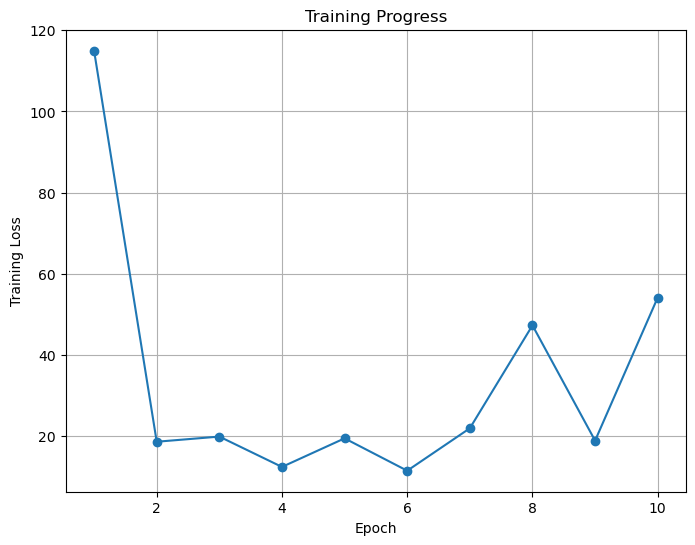

Iteration 2/20
Final Score for this game: 304
   8    4   32   16 
 128    2   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 292
   8    4    2   16 
 128   32   16    8 
   4   16    8    4 
  32    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 334
 128   64   32    2 
   4    2    4    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 202
   2    4   16    8 
  64   32    8    4 
  32    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 64
Final Score for this game: 220
   2   32    2   16 
  32    2   32    8 
   4   32    8    4 
  32    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 114
   2   16    4    2 
  16    4    2    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 16
Final Score for this game: 198
  16    2   16    8 
  64   16    4    2 
  32    8    2    4 
  16    2    4    2 
Highest Tile Achieved

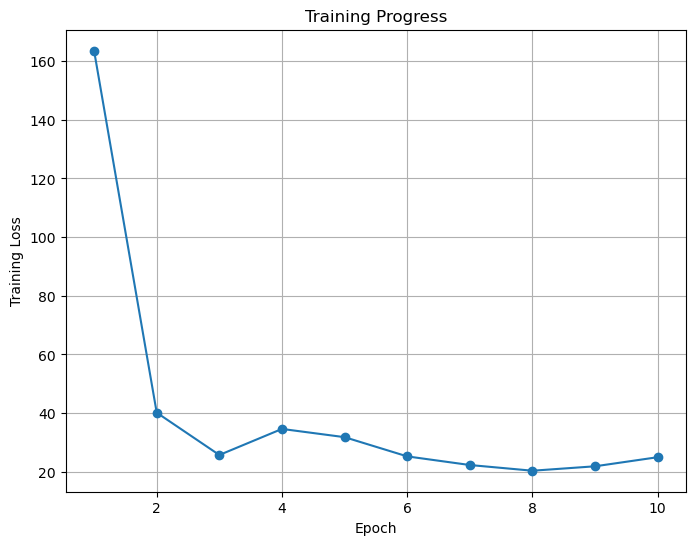

Iteration 3/20
Final Score for this game: 306
 128   64   16    8 
  32   16    8    4 
   4    8    4    2 
   2    4    2    4 
Highest Tile Achieved: 128
Score after 100 moves: 368
 128   32   16    8 
   4   32    8    2 
  64    8    4    8 
  32   16    4    2 
Final Score for this game: 630
 256  128   32   16 
   4   32   16    8 
  64   16    8    4 
  32    8    4    2 
Highest Tile Achieved: 256
Final Score for this game: 214
  64   32   16    8 
  32    2    8    4 
  16    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 64
Final Score for this game: 150
  16    8    4    2 
   4    2   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 140
  32    8    4    2 
   8    2    8    4 
  16    8    4    2 
  32    4    2    4 
Highest Tile Achieved: 32
Final Score for this game: 152
   2    8    2   16 
   8    2   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game:

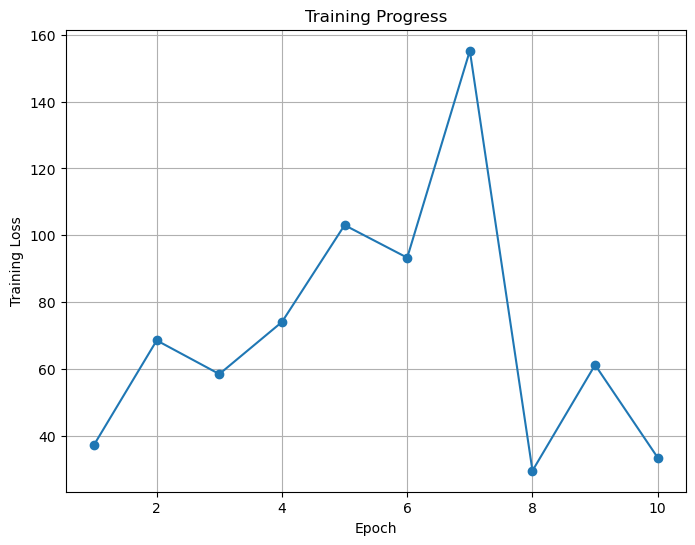

Iteration 4/20
Final Score for this game: 144
  32   16    4    2 
   4    2   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Score after 100 moves: 370
 128   64   32   16 
  32    2   16    4 
   4   16    8    2 
  32    8    4    2 
Final Score for this game: 400
 128   64   32   16 
  32    2   16    8 
   4   32    8    4 
  32   16    4    2 
Highest Tile Achieved: 128
Final Score for this game: 204
  64   16    8    2 
   4    2   16    8 
  32   16    8    4 
  16    2    4    2 
Highest Tile Achieved: 64
Final Score for this game: 184
  64    8    2   16 
   8    2   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 198
  64    8    4    2 
  32    4   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 194
  16    4    2   16 
   8   64   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 

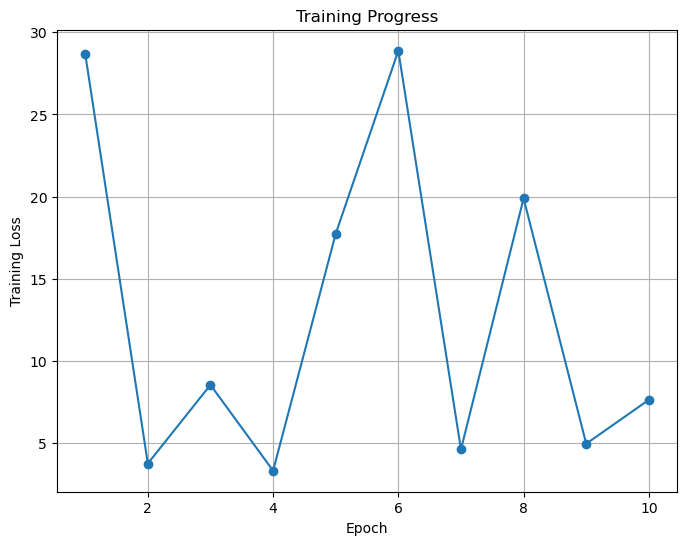

Iteration 5/20
Final Score for this game: 294
   2   64   32   16 
  64    2   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 300
   4   64   32    2 
 128   16    2    8 
   2    4    8    4 
   4   16    4    2 
Highest Tile Achieved: 128
Final Score for this game: 208
   8    4   32   16 
   2   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 258
  32    2    4    2 
   8   64   16    8 
  64   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 338
 128   64   32    8 
   8   32    8    4 
   2   16    4    2 
  16    8    2    4 
Highest Tile Achieved: 128
Final Score for this game: 246
 128    8    4    2 
   2   16    2    8 
  32    2    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Score after 100 moves: 356
   8  128   32   16 
   2   32   16    8 
  64   16    4    2 
  16    8    2    2 
Final Score for this game

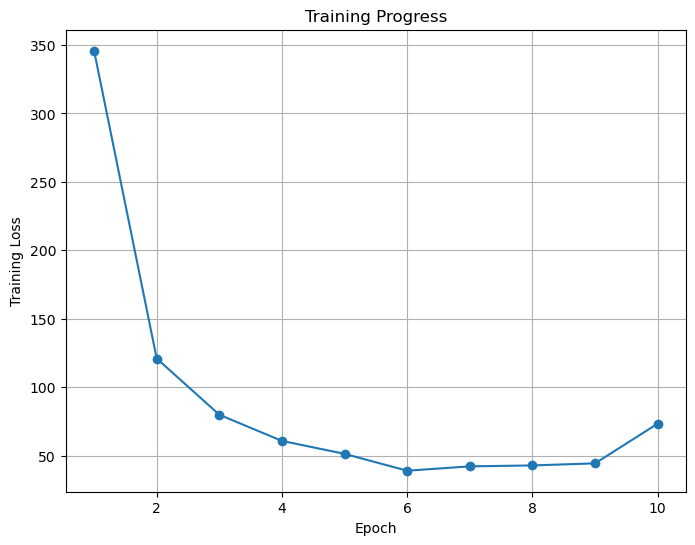

Iteration 6/20
Final Score for this game: 188
  64    8    4    2 
   8    2   16    8 
   2   16    8    4 
  32    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 296
   2   64   16    2 
 128    8    2    8 
   8   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 126
   4   16    8    4 
  32    8    4    2 
   8    4    2    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 310
  32    2   32   16 
   2   64   16    8 
  64   16    8    4 
  32    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 194
   8   32    2   16 
  16    2   32    8 
   4   32    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 114
   2   16    4    2 
   8    4    2    4 
  32   16    4    2 
   2    4    8    4 
Highest Tile Achieved: 32
Final Score for this game: 246
  64    8    4    2 
   8   32    8    4 
  64   16    4    2 
  16    8    2    4 
Highest Tile Achieved: 

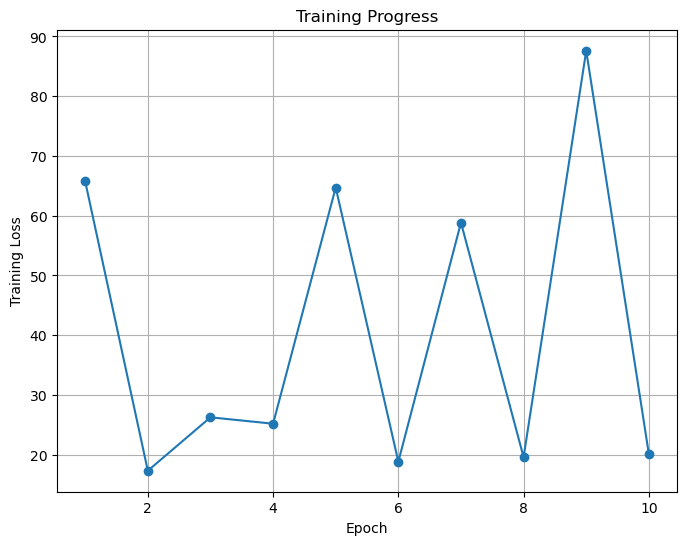

Iteration 7/20
Score after 100 moves: 370
 128   64   16    8 
   2   32    8    4 
  64    2    8    4 
  16    8    4    2 
Final Score for this game: 436
 128   64   32   16 
   2   32   16    8 
  64   16    8    4 
  32    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 266
  64    4    2   16 
   2   32   16    8 
  64   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 234
  32    4    2   16 
   2   32   16    8 
  64   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 124
  16    2   16    2 
   8   16    2    4 
  32    2    4    2 
   8    4    2    4 
Highest Tile Achieved: 32
Score after 100 moves: 390
   2   64   16    8 
 128   32    8    4 
  64    8    8    2 
  32    2    8    4 
Final Score for this game: 394
   2   64   16    8 
 128   32    8    4 
  64   16    4    2 
  32    2    8    4 
Highest Tile Achieved: 128
Final Score for this game: 240
   2   64    4    2 
  64

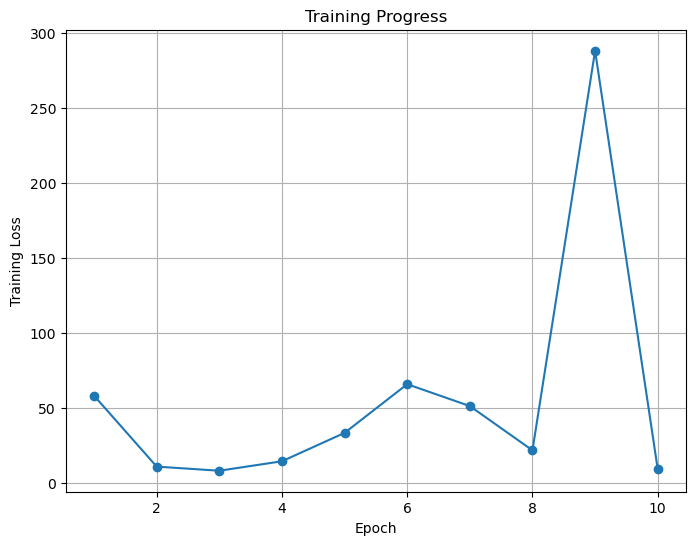

Iteration 8/20
Final Score for this game: 252
   2  128    2    4 
   4   32   16    8 
   2   16    4    2 
  16    4    8    4 
Highest Tile Achieved: 128
Final Score for this game: 252
 128   32    4   16 
   8    2   16    8 
   4   16    4    2 
   2    4    2    4 
Highest Tile Achieved: 128
Score after 100 moves: 356
   2  128    4   16 
 128   16   16    8 
  16    2    4    2 
   2    8    2    2 
Final Score for this game: 380
   2  128    4   16 
 128   32   16    8 
  16    2    8    4 
   2    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 182
   2   64    8   16 
  32   16    4    2 
   8    2    8    4 
   2    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 350
 128    4   64   16 
  64   16    2    8 
  16    4    8    4 
   8    2    4    2 
Highest Tile Achieved: 128
Final Score for this game: 252
  64   32   16   32 
  32   16    8    4 
  16    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 64
Final Score for this gam

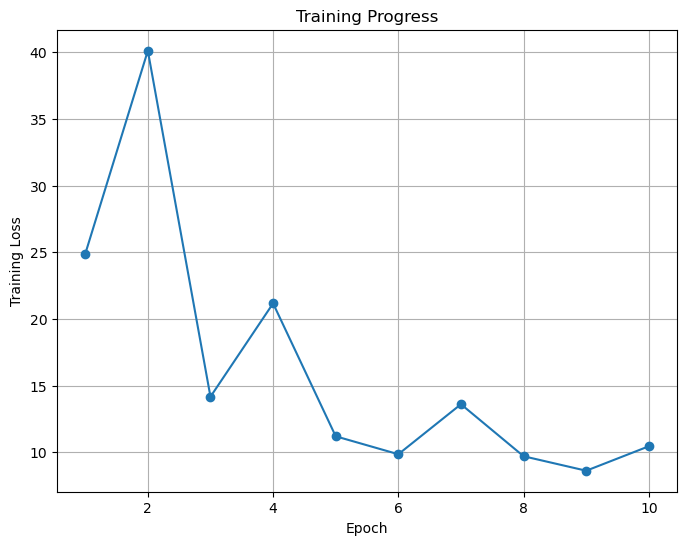

Iteration 9/20
Final Score for this game: 164
   2    8   32   16 
   4    2   16    8 
   2   16    8    4 
  32    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 152
   2   32    4    2 
  32    4   16    8 
   8   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 268
   2   64   32   16 
   8   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Score after 100 moves: 374
 128   64    8   16 
  64   32    2    8 
  16    8    8    2 
   8    4    4    2 
Final Score for this game: 594
 256  128    2   16 
  64   32   16    8 
  32    8    4    2 
  16    4    2    4 
Highest Tile Achieved: 256
Final Score for this game: 120
  16    8    4    2 
   4    2   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 16
Final Score for this game: 130
   2   16   32    2 
  32    4    8    4 
   4    2    4    2 
   8    4    2    4 
Highest Tile Achieved: 32
Final Score for this game: 

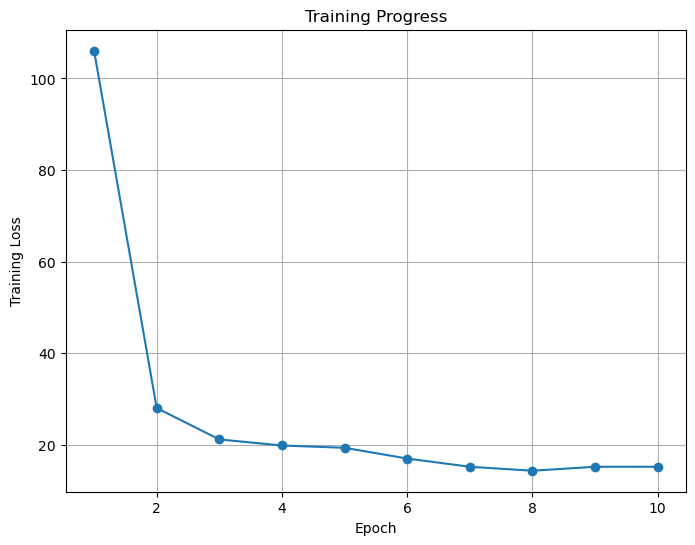

Iteration 10/20
Score after 100 moves: 390
 128  128   32    4 
  32    2    4   16 
  16    8    2    2 
   8    4    2    2 
Final Score for this game: 528
 256   64    8   16 
  64   16   32    8 
  32    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 256
Final Score for this game: 168
   2    4   32   16 
   4   32   16    8 
   2   16    8    2 
  16    4    2    4 
Highest Tile Achieved: 32
Final Score for this game: 330
   8   64   32   16 
  64   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 244
   4   64   32    2 
   2   32    2   16 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 210
  64    8   32   16 
  16    2   16    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 296
   4    2   64   16 
  64   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game:

C:\Users\leoth\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/10, Loss: 1.0296275615692139
Epoch 4/10, Loss: 0.04680921509861946
Epoch 5/10, Loss: 1.1456505060195923
Checkpoint saved at epoch 5
Epoch 6/10, Loss: 4.417703628540039
Epoch 7/10, Loss: 5.887709617614746
Epoch 8/10, Loss: 4.047181129455566
Epoch 9/10, Loss: 0.03917603939771652
Epoch 10/10, Loss: 0.7349498867988586
Checkpoint saved at epoch 10


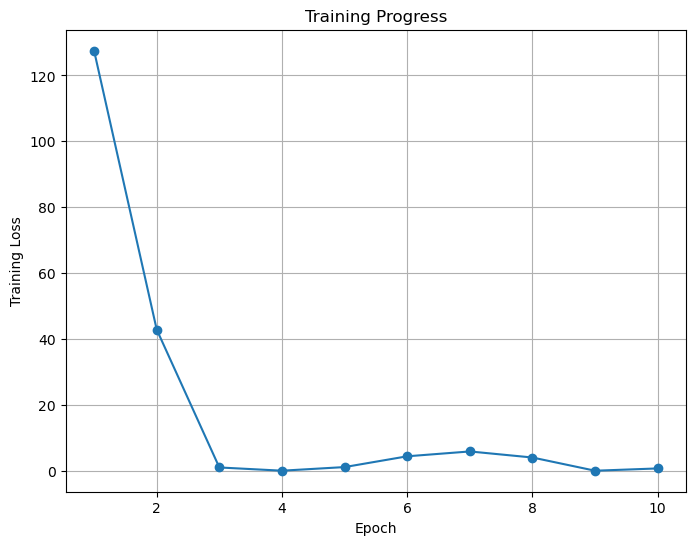

Iteration 11/20
Final Score for this game: 134
   8    2   32    2 
  32   16    4    8 
   8    4    2    4 
   4    2    4    2 
Highest Tile Achieved: 32
Final Score for this game: 208
   8    4   32   16 
   2   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 150
  32    8    4   16 
  16    4   16    8 
   2   16    8    2 
   4    8    2    4 
Highest Tile Achieved: 32
Final Score for this game: 228
   8    2   64   16 
   2   32   16    2 
  32   16    4    8 
  16    4    2    4 
Highest Tile Achieved: 64
Final Score for this game: 318
   2  128    4    2 
  64    4   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 290
   4    2   64   16 
  64   32   16    8 
  32   16    2    4 
  16    8    4    2 
Highest Tile Achieved: 64
Score after 100 moves: 380
 128    2   64    2 
  64   32   16    8 
  32    8    0    2 
  16    4    0    2 
Final Score for this game:

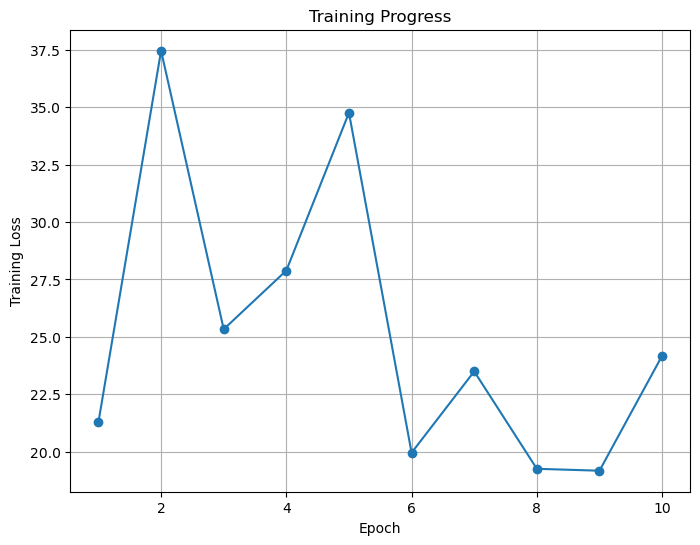

Iteration 12/20
Final Score for this game: 254
   8   64   32   16 
   2   32   16    8 
  32    2    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 248
  16    4   64   16 
   2   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 134
   2    8    2   16 
  32    2   16    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 256
   2  128    8    4 
  32    2   16    2 
   4   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 316
   8   64   32   16 
  64   32    2    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 234
 128    8   16    2 
   4   16    8    4 
  16    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 128
Final Score for this game: 308
 128   32    8    4 
  64   16    2    8 
  16    2    8    4 
   2    8    4    2 
Highest Tile Achieved

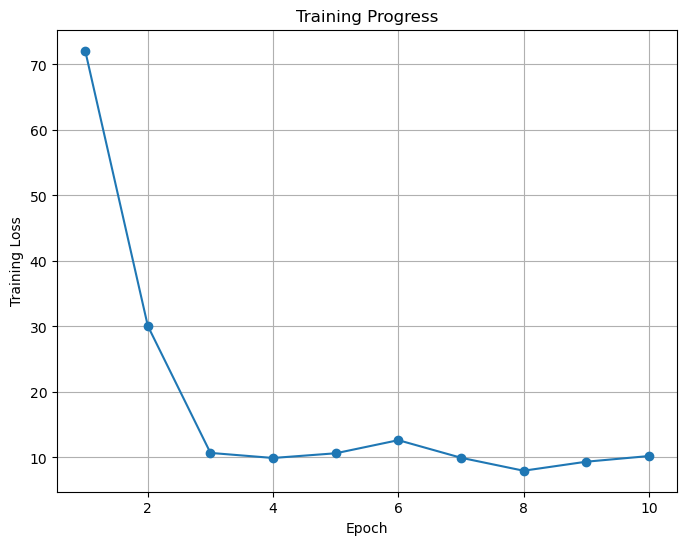

Iteration 13/20
Final Score for this game: 306
 128    8   64   16 
  16    2   16    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 324
   2   64   32   16 
  64   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 226
   4   64    8   32 
  16    2   32    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 114
  32    2    8   16 
   8    4    2    8 
   4    2    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 270
   4    2   64   16 
  64   32   16    8 
  32    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 64
Final Score for this game: 200
  32    4   64    2 
   8   32    2    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 282
 128    2   32   16 
   2   32   16    8 
  16    8    2    4 
   8    2    4    2 
Highest Tile Achieved:

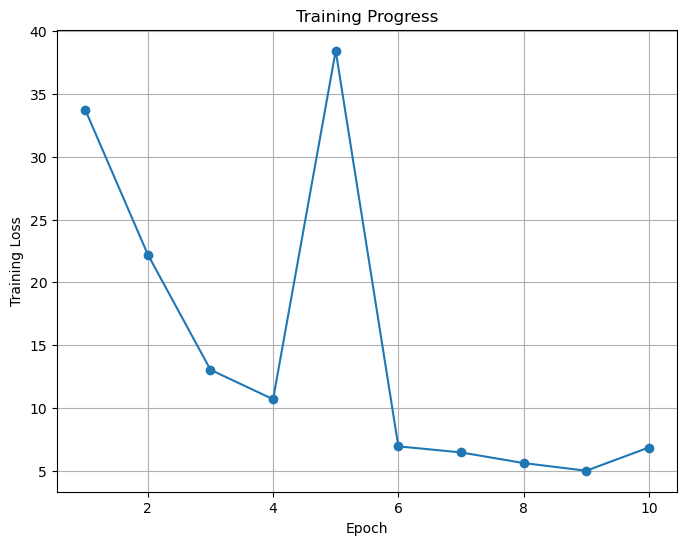

Iteration 14/20
Final Score for this game: 214
   4   64    8    2 
  64    8    2   16 
   4    2   16    8 
   2    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 262
   8   64   32   16 
   2   32   16    8 
  32   16    4    2 
  16    8    2    4 
Highest Tile Achieved: 64
Final Score for this game: 202
  32    2   32   16 
  16   32   16    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 326
   8  128   32   16 
   2   32   16    2 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Score after 100 moves: 370
   2  128   32    2 
 128    4    2   16 
  32    8    4    2 
   4    2    2    2 
Final Score for this game: 404
   2  128   32    2 
 128    4    2   16 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Score after 100 moves: 384
 256   32   16    2 
  16    2   16    2 
   4   16    2    4 
   2    8    4    2 
Final Score for this game: 408
 256   64    8    2 
  1

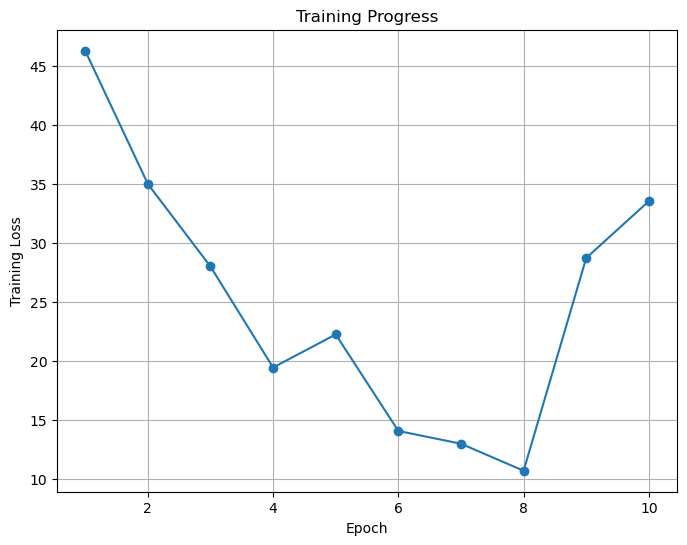

Iteration 15/20
Final Score for this game: 230
   2    4   64   16 
  64    2    4    8 
  32    4    2    4 
  16    2    4    2 
Highest Tile Achieved: 64
Final Score for this game: 166
  32    4   32   16 
   8   32    8    4 
   4    8    4    2 
   2    4    2    4 
Highest Tile Achieved: 32
Final Score for this game: 206
  64   16   32   16 
  16    4    2    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 90
  32    4    8    2 
   2    8    2    4 
   4    2    8    2 
   2    4    2    4 
Highest Tile Achieved: 32
Final Score for this game: 352
   4  128    8    2 
  64   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 152
  32    2   32   16 
   8    4   16    8 
   4    2    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 136
  32   16    2   16 
   8    4   16    8 
   4    2    8    4 
   2    8    4    2 
Highest Tile Achieved: 

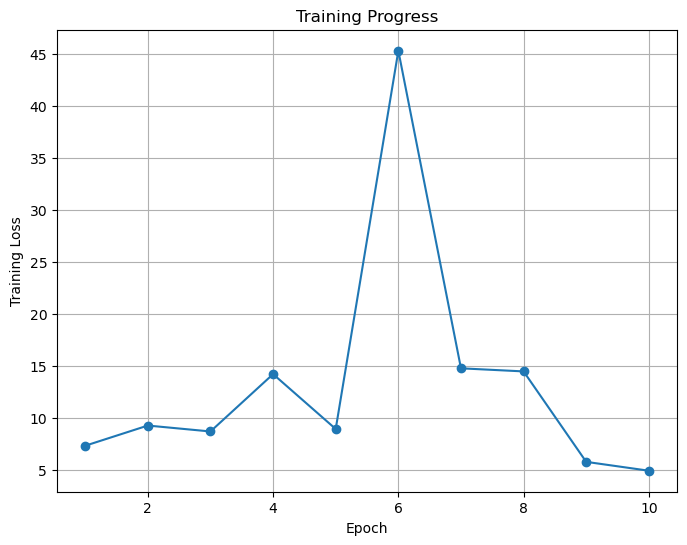

Iteration 16/20
Final Score for this game: 194
  32    2   32   16 
   8   32   16    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 254
   4   64   32   16 
  64   16    2    8 
  16    4    8    4 
   8    2    4    2 
Highest Tile Achieved: 64
Final Score for this game: 160
   8    4   32    2 
   4   32    2   16 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 184
   2   64   16    8 
  32    2    8    4 
  16    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 64
Final Score for this game: 172
  32    8   32   16 
  16    2   16    2 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 176
  32    4   32   16 
   4   32   16    2 
  16    4    2    4 
   4    2    4    2 
Highest Tile Achieved: 32
Final Score for this game: 180
  64    8   32   16 
   8    4   16    4 
   4    2    8    2 
   2    4    2    4 
Highest Tile Achieved: 

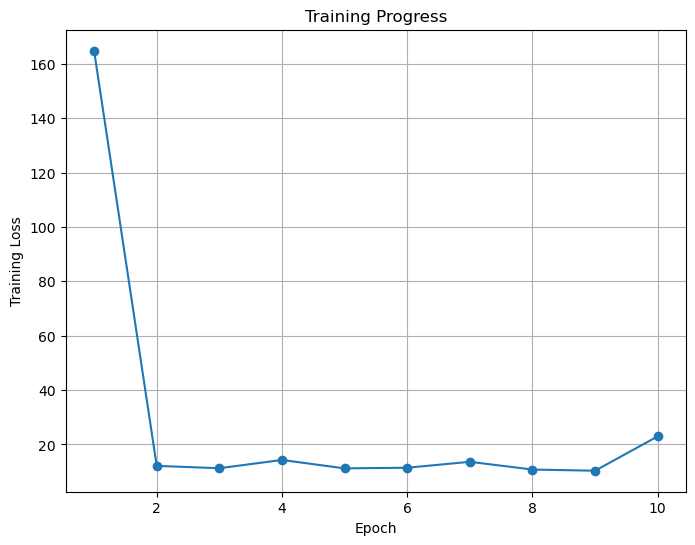

Iteration 17/20
Final Score for this game: 180
  64    4    2   16 
   8    2   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 326
  32    2   64   16 
   2   64   16    8 
  64   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 262
 128   32    4   16 
  32    2   16    2 
   8    4    2    4 
   4    2    4    2 
Highest Tile Achieved: 128
Score after 100 moves: 392
 128   64    4   16 
  64   32   16    8 
  16   16    4    4 
   8    8    2    2 
Final Score for this game: 422
 128   64    4   16 
  64   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 210
  64    4    8    2 
  32   16   32    4 
  16    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 64
Final Score for this game: 216
  64   32    2   16 
  32    8   16    8 
  16    4    2    4 
   4    2    4    2 
Highest Tile Achieved: 64
Final Score for this game

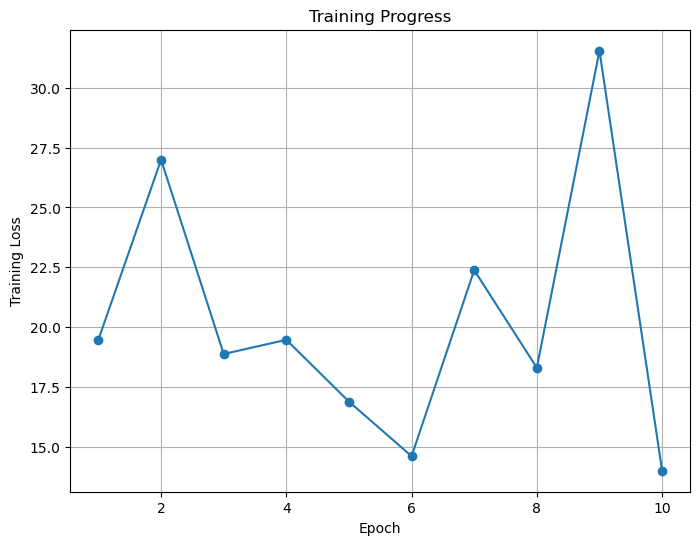

Iteration 18/20
Final Score for this game: 346
   2  128   64    2 
  64    8    4    8 
  32    4    2    4 
  16    2    4    2 
Highest Tile Achieved: 128
Final Score for this game: 170
  32    8   32   16 
   8    2   16    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 216
  32   64    2   16 
   4    2   16    8 
  32    8    4    2 
  16    4    2    4 
Highest Tile Achieved: 64
Final Score for this game: 226
   2   64   32   16 
  64    2   16    2 
   2    8    2    4 
   4    2    4    2 
Highest Tile Achieved: 64
Final Score for this game: 180
   8    4   32   16 
   4   32   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 96
  16    8   16    8 
   8    4    8    4 
   4    2    4    2 
   2    4    2    4 
Highest Tile Achieved: 16
Final Score for this game: 178
  32    4   32   16 
   2   32    8    4 
  16    8    4    2 
   8    4    2    4 
Highest Tile Achieved: 

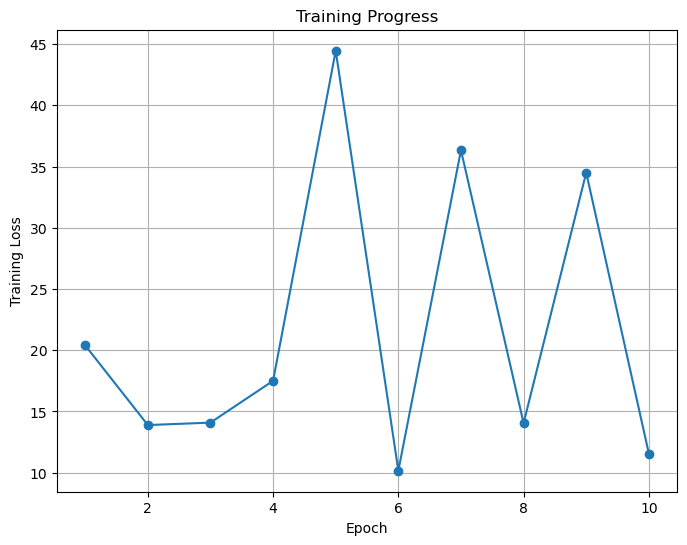

Iteration 19/20
Final Score for this game: 318
 128    4   32   16 
  64   16    4    8 
  16    8    2    4 
   8    2    4    2 
Highest Tile Achieved: 128
Final Score for this game: 264
   2   64   32   16 
  64    2   16    8 
   2   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 248
   2  128   32    2 
  16    2   16    8 
   4   16    2    4 
   2    8    4    2 
Highest Tile Achieved: 128
Score after 100 moves: 362
 128   64    2   32 
   2   32   16    8 
  32    8    8    2 
  16    4    4    4 
Final Score for this game: 368
 128   64    2   32 
   2   32   16    8 
  32   16    2    4 
  16    8    4    2 
Highest Tile Achieved: 128
Score after 100 moves: 360
 128    8   32   32 
  64   32    2    4 
  16   16    4    2 
   8    8    2    2 
Final Score for this game: 612
 256    8   64   16 
 128   32   16    2 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 256
Final Score for this game: 180
  64   32   16    2 
 

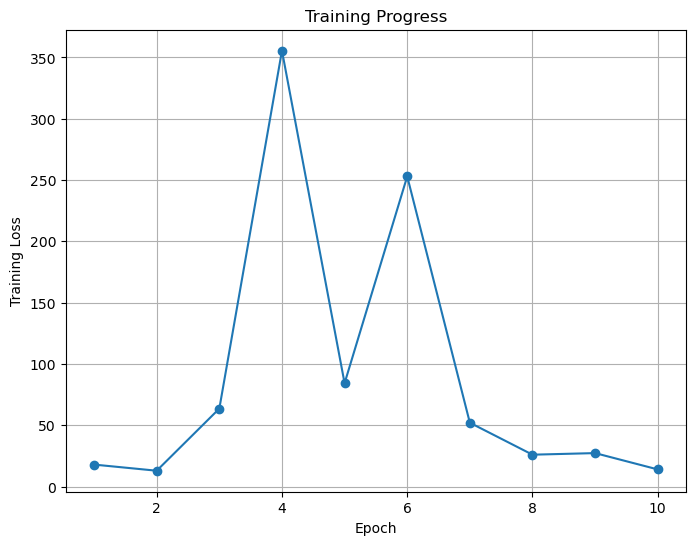

Iteration 20/20
Final Score for this game: 346
   2  128    2    4 
  64   32   16    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 362
   2  128    4   32 
  64   32   16    8 
  32    2    8    4 
  16    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 312
   4   64   32   16 
  64   32    2    8 
  32   16    8    4 
  16    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 340
 128    4   32   16 
  64   32   16    2 
  16    2    8    4 
   2    8    4    2 
Highest Tile Achieved: 128
Final Score for this game: 244
  32    2   64    2 
   8   64   16    8 
   4   16    8    4 
   2    8    4    2 
Highest Tile Achieved: 64
Final Score for this game: 124
  16   32    4   16 
   8    4    2    8 
   4    2    8    4 
   2    8    4    2 
Highest Tile Achieved: 32
Final Score for this game: 184
   4    2   32   16 
   2   32   16    2 
  32   16    2    4 
  16    2    4    2 
Highest Tile Achieve

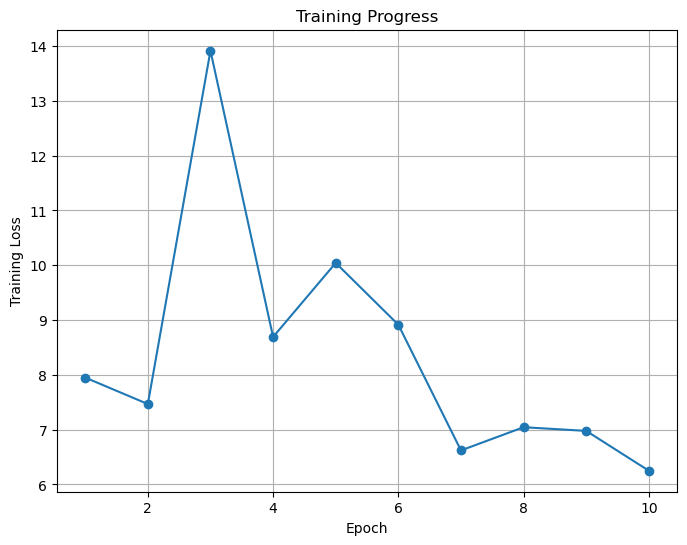

In [8]:
def main():
    num_games = 20  # Play 10 games for each iteration
    num_iterations = 50  # Number of self-play iterations
    
    # Determine the number of unique tile values
    max_tile = 131072  # Adjust this value based on your game's maximum tile value
    num_channels = int(np.log2(max_tile)) + 1
    
    neural_net = BoardEvaluator(num_channels)
    
    # Load the trained model if it exists
    model_path = 'trained_model.pth'
    if os.path.exists(model_path):
        neural_net.load_state_dict(torch.load(model_path))
        print("Loaded trained model from", model_path)
    
    mcts = MCTS(neural_net=neural_net, max_tile=max_tile)
    
    for iteration in range(num_iterations):
        print(f"Iteration {iteration+1}/{num_iterations}")
        
        all_states, all_moves, all_rewards = [], [], []
        for _ in range(num_games):
            states, moves, rewards = play_game(mcts, neural_net)
            all_states.extend(states)
            all_moves.extend(moves)
            all_rewards.extend(rewards)
        
        train_neural_net(neural_net, mcts, all_states, all_moves, all_rewards)

if __name__ == '__main__':
    main()